# Big-Five Factor Markers

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from itertools import cycle
import matplotlib.pyplot as plt

#Data Preparation
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder,label_binarize,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_predict

#Modelling
from sklearn.naive_bayes import CategoricalNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier

#Testing
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report,plot_confusion_matrix,accuracy_score,roc_curve,auc,roc_auc_score

# Data Overview

## Data Load

In [2]:
categorical_columns = [f"EXT{i}" for i in range(1, 11)] + \
                      [f"EST{i}" for i in range(1, 11)] + \
                      [f"AGR{i}" for i in range(1, 11)] + \
                      [f"CSN{i}" for i in range(1, 11)] + \
                      [f"OPN{i}" for i in range(1, 11)] + \
                      ['target']

float32_columns = [f"EXT{i}_E" for i in range(1, 11)] + \
                  [f"EST{i}_E" for i in range(1, 11)] + \
                  [f"AGR{i}_E" for i in range(1, 11)] + \
                  [f"CSN{i}_E" for i in range(1, 11)] + \
                  [f"OPN{i}_E" for i in range(1, 11)]

cat_types = {k: 'category' for k in categorical_columns}
float32_types = {k: 'float32' for k in float32_columns}
dtype = {**float32_types, **float32_types}
#dtype = {**cat_types, **float32_types}

df = pd.read_csv('dataset/BigFivePersonalityTest-TrainSet.csv', parse_dates = ['dateload'], dtype=dtype)
df.rename(columns={'Unnamed: 0':'id'},inplace = True)
pd.options.display.float_format = "{:,.2f}".format
pd.options.display.max_columns = 999
df.head()

,id,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,dateload,screenw,screenh,introelapse,testelapse,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err,target
0,441310,3.00,3.00,3.00,3.00,4.00,4.00,3.00,4.00,3.00,4.00,3.00,3.00,4.00,3.00,4.00,4.00,4.00,3.00,4.00,4.00,4.00,4.00,4.00,4.00,3.00,5.00,0.00,4.00,4.00,4.00,3.00,3.00,3.00,3.00,4.00,3.00,4.00,3.00,4.00,3.00,2.00,3.00,4.00,3.00,4.00,1.00,4.00,3.00,4.00,3.00,"6,462.00","2,273.00","1,625.00","4,960.00","6,040.00","3,983.00","3,608.00","3,376.00","3,216.00","4,544.00","2,913.00","13,480.00","3,008.00","3,496.00","4,640.00","2,274.00","2,080.00","2,535.00","2,545.00","1,719.00","5,432.00","4,696.00","2,319.00","1,944.00","5,008.00","2,698.00",0.00,"23,048.00","2,040.00","3,608.00","2,528.00","4,008.00","2,361.00","2,528.00","2,760.00","7,662.00","4,736.00","2,697.00","2,095.00","1,704.00","2,958.00","2,471.00","2,184.00","1,880.00","3,024.00","2,375.00","2,456.00","1,840.00","2,016.00","2,232.00",2017-06-25 19:21:21,"1,920.00","1,080.00",7.00,186.00,21,1,US,35.057,-79.0147,C
1,985842,3.00,4.00,4.00,3.00,2.00,3.00,5.00,2.00,4.00,4.00,3.00,4.00,4.00,1.00,2.00,2.00,4.00,4.00,4.00,4.00,2.00,4.00,2.00,4.00,2.00,4.00,2.00,4.00,4.00,5.00,3.00,3.00,3.00,2.00,2.00,4.00,3.00,3.00,3.00,2.00,4.00,1.00,5.00,1.00,4.00,1.00,5.00,4.00,4.00,5.00,"35,691.00","2,218.00","1,492.00","1,685.00","2,667.00","1,757.00","3,513.00",906.00,"1,211.00","2,013.00","1,401.00","2,884.00","1,100.00","1,276.00","1,416.00","5,026.00","1,142.00","1,518.00","1,761.00","2,382.00","1,426.00",995.00,"1,873.00","1,705.00","1,259.00","1,215.00","1,607.00","2,478.00","1,115.00","1,064.00","1,618.00","2,390.00","1,139.00","1,925.00","1,356.00","3,875.00","1,291.00","2,916.00","1,315.00","2,181.00","1,122.00",834.00,"2,201.00","10,365.00","1,283.00","1,490.00","2,185.00","1,318.00","1,227.00","1,247.00",2018-10-24 08:10:07,"1,366.00",768.00,15.00,133.00,7,14,SG,1.2931,103.8558,N
2,628988,3.00,3.00,2.00,3.00,2.00,3.00,1.00,2.00,2.00,5.00,2.00,4.00,2.00,1.00,4.00,3.00,2.00,3.00,4.00,4.00,3.00,4.00,1.00,2.00,4.00,4.00,2.00,2.00,4.00,3.00,2.00,2.00,2.00,4.00,1.00,4.00,4.00,4.00,0.00,2.00,2.00,2.00,5.00,1.00,3.00,2.00,3.00,3.00,4.00,4.00,"30,932.00","2,514.00","4,927.00","8,252.00","7,885.00","3,500.00","3,973.00","1,231.00","1,117.00","1,309.00",985.00,926.00,"1,133.00","5,290.00","33,489.00","3,101.00","2,600.00","12,058.00","6,068.00",684.00,"13,743.00","1,823.00","2,268.00","2,891.00","4,402.00","4,891.00","6,840.00","2,899.00","11,554.00","2,416.00","2,498.00","3,435.00","11,042.00","12,779.00","1,510.00","4,093.00","4,769.00","12,279.00",0.00,"9,355.00","4,027.00","4,616.00","1,974.00","2,000.00","3,203.00","4,126.00","2,514.00","4,169.00","1,800.00","5,787.00",2018-02-26 18:56:06,"1,680.00","1,050.00",3.00,286.00,16,11,HK,22.25,114.1667,N
3,704960,3.00,3.00,2.00,3.00,3.00,4.00,1.00,3.00,4.00,5.00,4.00,2.00,5.00,3.00,2.00,4.00,4.00,3.00,4.00,3.00,4.00,3.00,4.00,4.00,2.00,5.00,2.00,3.00,4.00,5.00,3.00,5.00,5.00,3.00,2.00,4.00,1.00,2.00,5.00,3.00,3.00,4.00,3.00,3.00,3.00,2.00,3.00,3.00,5.00,3.00,"8,624.00","2,872.00","5,600.00","3,152.00","5,775.00","1,753.00","4,208.00","5,648.00","7,136.00","1,704.00","2,361.00","7,576.00","2,360.00","5,584.00","3,328.00","2,728.00","2,567.00","2,880.00","1,120.00","4,376.00","3,113.00","1,681.00","2,400.00","3,415.00","3,921.00","3,120.00","4,672.00","4,344.00","4,064.00","3,457.00","3,071.00","2,920.00","2,792.00","1,9

## Data Exploration

### Statistics

In [3]:
print(f'Train dataset has {df.shape[0]} rows and {df.shape[1]} features.')
df.describe()

Train dataset has 964573 rows and 112 features.


,id,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,EXT8,EXT9,EXT10,EST1,EST2,EST3,EST4,EST5,EST6,EST7,EST8,EST9,EST10,AGR1,AGR2,AGR3,AGR4,AGR5,AGR6,AGR7,AGR8,AGR9,AGR10,CSN1,CSN2,CSN3,CSN4,CSN5,CSN6,CSN7,CSN8,CSN9,CSN10,OPN1,OPN2,OPN3,OPN4,OPN5,OPN6,OPN7,OPN8,OPN9,OPN10,EXT1_E,EXT2_E,EXT3_E,EXT4_E,EXT5_E,EXT6_E,EXT7_E,EXT8_E,EXT9_E,EXT10_E,EST1_E,EST2_E,EST3_E,EST4_E,EST5_E,EST6_E,EST7_E,EST8_E,EST9_E,EST10_E,AGR1_E,AGR2_E,AGR3_E,AGR4_E,AGR5_E,AGR6_E,AGR7_E,AGR8_E,AGR9_E,AGR10_E,CSN1_E,CSN2_E,CSN3_E,CSN4_E,CSN5_E,CSN6_E,CSN7_E,CSN8_E,CSN9_E,CSN10_E,OPN1_E,OPN2_E,OPN3_E,OPN4_E,OPN5_E,OPN6_E,OPN7_E,OPN8_E,OPN9_E,OPN10_E,screenw,screenh,introelapse,testelapse,endelapse,IPC
count,"964,573.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,863.00","962,611.00","962,611.00","962,611.00","962,863.00","964,573.00","964,573.00"
mean,"507,687.98",2.65,2.77,3.29,3.14,3.28,2.40,2.77,3.41,2.96,3.56,3.29,3.16,3.85,2.66,2.84,2.84,3.05,2.68,3.09,2.77,2.26,3.83,2.26,3.93,2.27,3.74,2.20,3.69,3.79,3.59,3.30,2.93,3.98,2.62,2.63,2.83,3.70,2.47,3.20,3.59,3.65,2.08,4.00,2.00,3.79,1.89,3.98,3.18,4.12,3.96,"98,303.90","7,868.34","11,745.72","7,488.71","7,204.35","7,520.51","11,095.22","7,097.06","6,189.11","7,556.75","9,611.44","9,304.36","7,805.62","10,855.95","10,405.29","8,276.98","6,979.06","8,080.31","5,464.28","4,760.57","18,399.51","8,656.28","6,649.63","9,090.83","11,311.81","6,211.18","8,382.48","9,099.23","5,352.74","6,098.79","12,310.78","10,173.75","8,854.17","9,184.09","9,131.42","11,617.35","5,615.05","10,904.71","5,500.40","11,005.06","8,574.33","13,270.75","7,135.83","13,599.01","6,264.19","8,307.59","7,780.77","5,470.92","6,385.60","5,428.93","1,149.46",826.32,957.42,660.47,"2,777.03",10.45
std,"293,090.74",1.26,1.32,1.22,1.24,1.28,1.23,1.40,1.27,1.35,1.31,1.35,1.23,1.16,1.25,1.27,1.33,1.29,1.34,1.30,1.32,1.34,1.14,1.28,1.13,1.17,1.22,1.12,1.10,1.17,1.08,1.18,1.39,1.04,1.25,1.27,1.42,1.13,1.14,1.28,1.05,1.16,1.11,1.10,1.09,0.99,1.10,1.01,1.26,1.04,1.03,"4,992,401.50","441,714.69","2,386,077.75","326,273.72","616,677.00","580,364.75","2,246,859.25","377,292.97","254,007.56","2,200,702.25","1,273,595.25","638,532.81","726,467.69","1,131,015.38","2,235,275.75","719,566.44","398,919.06","2,210,038.50","449,060.94","174,032.91","1,772,232.62","722,187.31","263,899.03","773,435.00","2,235,321.00","343,937.00","684,252.94","1,436,147.25","163,695.05","312,378.41","1,335,930.00","576,368.50","1,246,966.62","731,616.06","1,040,988.88","2,291,148.50","275,729.19","513,744.66","414,599.50","2,262,755.75","955,851.50","1,253,111.75","372,066.84","3,126,721.50","343,716.78","574,789.44","598,264.56","269,737.75","440,852.66","452,223.84",560.05,180.26,"51,912.03","15,824.76","1,522,388.82",39.79
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

Negative Values and Outliers can be found in time columns, this values will be transformed in **Data Transformation** section.

### Missing Values

In [4]:
df.drop(labels= ['id'],axis=1,inplace = True)
df.replace(to_replace = 0, value = np.nan,inplace = True)
df.isnull().sum()[df.isnull().sum()>0].to_frame('Nulls %').sort_values(by = 'Nulls %')/len(df)*100

,Nulls %
country,0.01
target,0.18
testelapse,0.18
introelapse,0.21
screenh,0.47
...,...
AGR6_E,1.62
EST2_E,1.63
EST6_E,1.67
EST4_E,1.68


The NaN values represent the 2% of the dataset in the worst case, then this values will be dropped.

In [5]:
df.dropna(axis = 0,inplace = True)

Check the metadata of the dataframe.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822925 entries, 1 to 964572
Columns: 111 entries, EXT1 to target
dtypes: datetime64[ns](1), float32(50), float64(54), int64(2), object(4)
memory usage: 546.2+ MB


### Columns in the Dataset

In [7]:
df.columns.values

array(['EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7', 'EXT8',
       'EXT9', 'EXT10', 'EST1', 'EST2', 'EST3', 'EST4', 'EST5', 'EST6',
       'EST7', 'EST8', 'EST9', 'EST10', 'AGR1', 'AGR2', 'AGR3', 'AGR4',
       'AGR5', 'AGR6', 'AGR7', 'AGR8', 'AGR9', 'AGR10', 'CSN1', 'CSN2',
       'CSN3', 'CSN4', 'CSN5', 'CSN6', 'CSN7', 'CSN8', 'CSN9', 'CSN10',
       'OPN1', 'OPN2', 'OPN3', 'OPN4', 'OPN5', 'OPN6', 'OPN7', 'OPN8',
       'OPN9', 'OPN10', 'EXT1_E', 'EXT2_E', 'EXT3_E', 'EXT4_E', 'EXT5_E',
       'EXT6_E', 'EXT7_E', 'EXT8_E', 'EXT9_E', 'EXT10_E', 'EST1_E',
       'EST2_E', 'EST3_E', 'EST4_E', 'EST5_E', 'EST6_E', 'EST7_E',
       'EST8_E', 'EST9_E', 'EST10_E', 'AGR1_E', 'AGR2_E', 'AGR3_E',
       'AGR4_E', 'AGR5_E', 'AGR6_E', 'AGR7_E', 'AGR8_E', 'AGR9_E',
       'AGR10_E', 'CSN1_E', 'CSN2_E', 'CSN3_E', 'CSN4_E', 'CSN5_E',
       'CSN6_E', 'CSN7_E', 'CSN8_E', 'CSN9_E', 'CSN10_E', 'OPN1_E',
       'OPN2_E', 'OPN3_E', 'OPN4_E', 'OPN5_E', 'OPN6_E', 'OPN7_E',
       'OPN8_E', 'OPN9_

**Question Columns**  
Find below further information about the question columns  

|Column| Question|
|---|:---|
|EXT1|I am the life of the party
|EXT2|I don't talk a lot
|EXT3|I feel comfortable around people
|EXT4|I keep in the background
|EXT5|I start conversations
|EXT6|I have little to say
|EXT7|I talk to a lot of different people at parties
|EXT8|I don't like to draw attention to myself
|EXT9|I don't mind being the center of attention
|EXT10|I am quiet around strangers
|EST1|I get stressed out easily
|EST2|I am relaxed most of the time
|EST3|I worry about things
|EST4|I seldom feel blue
|EST5|I am easily disturbed
|EST6|I get upset easily
|EST7|I change my mood a lot
|EST8|I have frequent mood swings
|EST9|I get irritated easily
|EST10|I often feel blue
|AGR1|I feel little concern for others
|AGR2|I am interested in people
|AGR3|I insult people
|AGR4|I sympathize with others' feelings
|AGR5|I am not interested in other people's problems
|AGR6|I have a soft heart
|AGR7|I am not really interested in others
|AGR8|I take time out for others
|AGR9|I feel others' emotions
|AGR10|I make people feel at ease
|CSN1|I am always prepared
|CSN2|I leave my belongings around
|CSN3|I pay attention to details
|CSN4|I make a mess of things
|CSN5|I get chores done right away
|CSN6|I often forget to put things back in their proper place
|CSN7|I like order
|CSN8|I shirk my duties
|CSN9|I follow a schedule
|CSN10|I am exacting in my work
|OPN1|I have a rich vocabulary
|OPN2|I have difficulty understanding abstract ideas
|OPN3|I have a vivid imagination
|OPN4|I am not interested in abstract ideas
|OPN5|I have excellent ideas
|OPN6|I do not have a good imagination
|OPN7|I am quick to understand things
|OPN8|I use difficult words
|OPN9|I spend time reflecting on things
|OPN10|I am full of ideas

The scale was labeled 1=Disagree, 3=Neutral, 5=Agree  
The time spent on each question is also recorded in milliseconds These are the variables ending in **\_E**  

**Other Columns**  

|Column|Description|
|---|:---|
|dateload|The timestamp when the survey was started
|screenw|The width the of user's screen in pixels
|screenh|The height of the user's screen in pixels
|introelapse|The time in seconds spent on the landing page
|testelapse|The time in seconds spent on the page with the survey questions
|endelapse|The time in seconds spent on the finalization page 
|IPC|The number of records from the user's IP address in the dataset
|country|The country*
|lat_appx_lots_of_err|Approximate latitude of user*
|long_appx_lots_of_err|Approximate longitude of user*
|target|The trait with max value of the test

*Determined by technical information

### Question's Answer Distribution

#### Globally

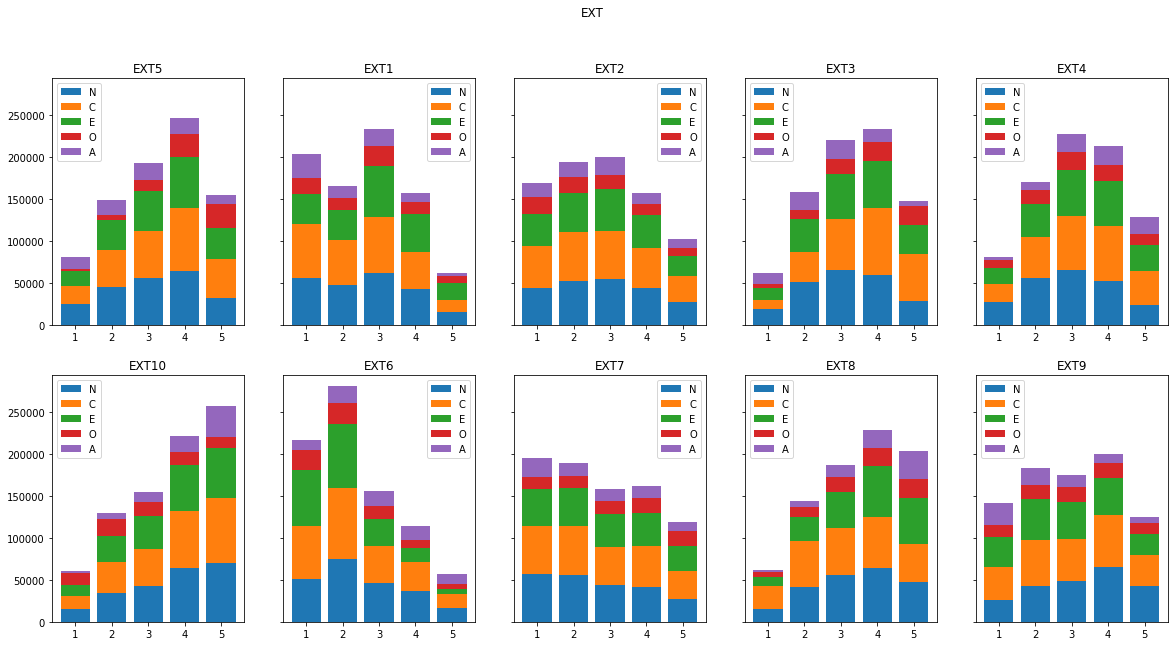

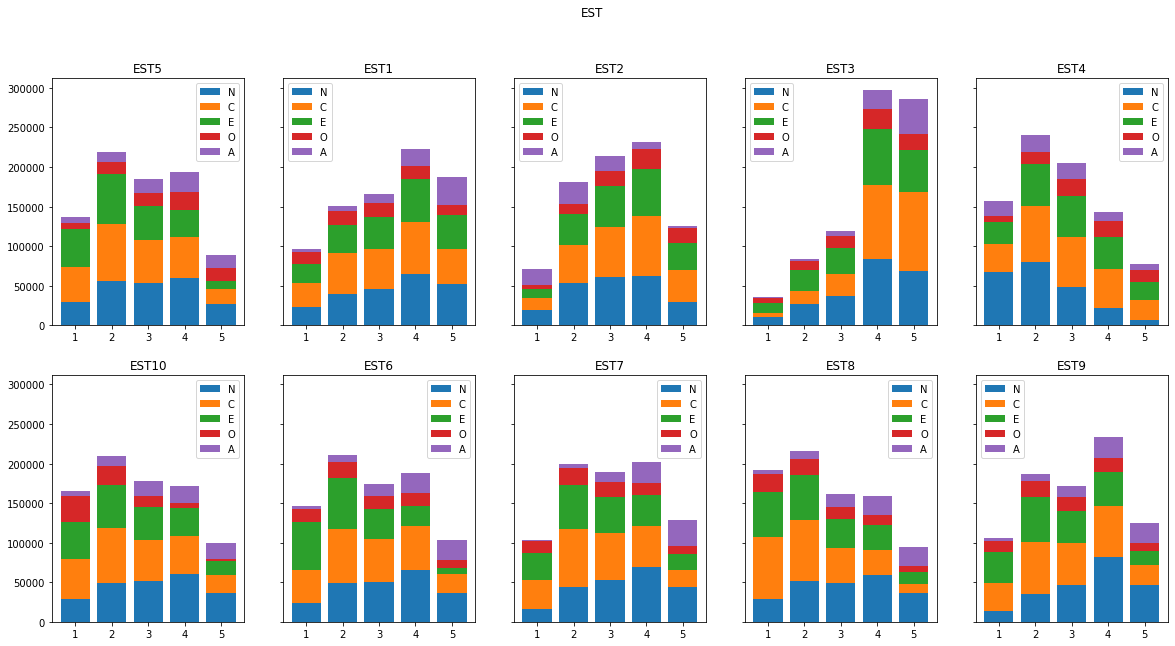

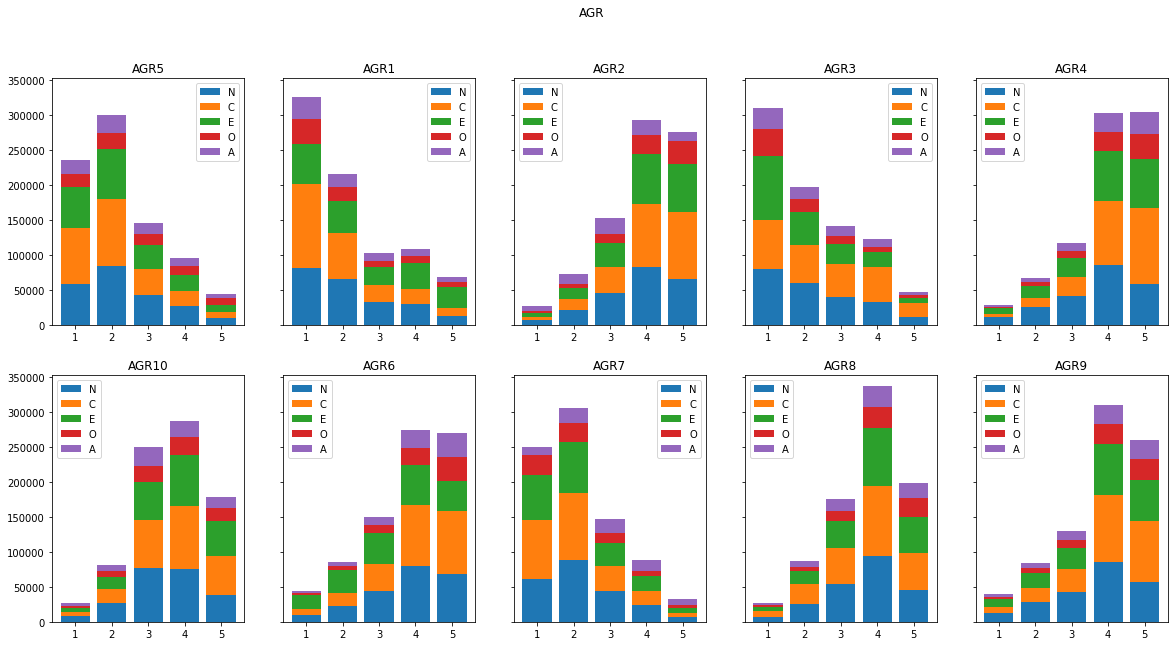

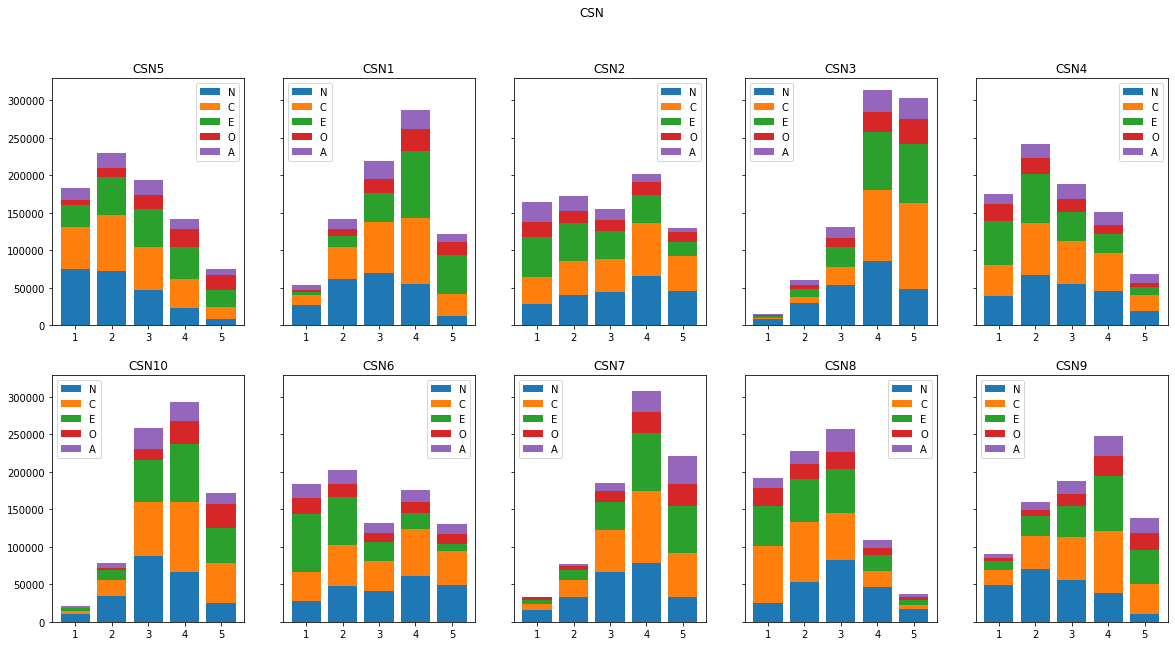

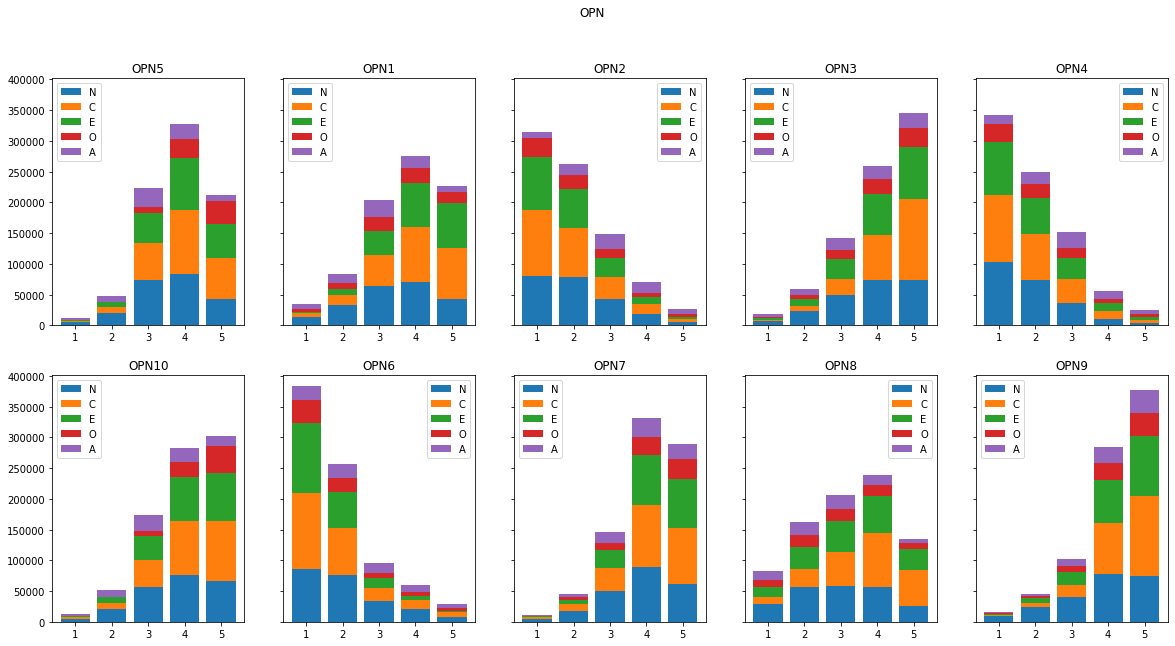

In [8]:
q_types = ['EXT', 'EST', 'AGR', 'CSN', 'OPN']
targets = df['target'].unique()

for q in q_types:

    questions = [f"{q}{i}" for i in range(1, 11)]
    fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(20, 10), sharey=True)
    fig.suptitle(q)
    for i, question in enumerate(questions):
        ax = axis[round((i+1)/10), (i + 1) % 5]
        ax.set_title(question)
        targets_data = [df[df['target'] == target][question].value_counts().sort_index() for target in targets]
        cumsum = np.cumsum(targets_data, axis=0)
        for i in range(len(targets_data)):
            if i == 0:
                ax.bar(targets_data[i].index, targets_data[i], label=targets[i])
            else:
                ax.bar(targets_data[i].index, targets_data[i], bottom=cumsum[i - 1], label=targets[i])

            ax.legend()

#### Per target

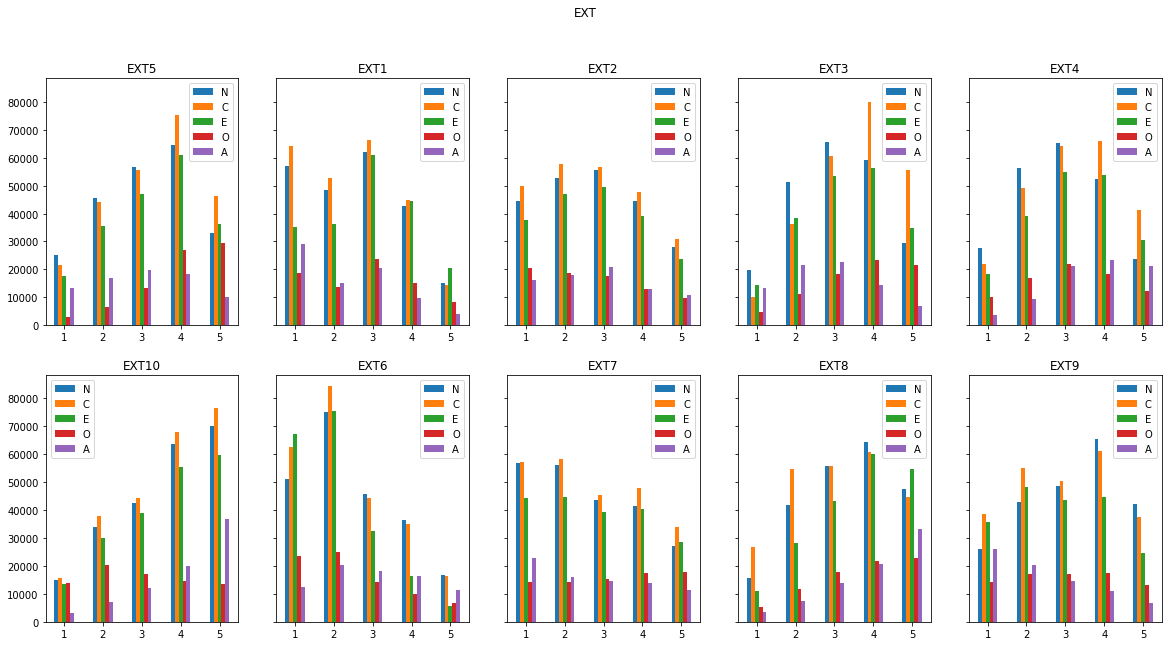

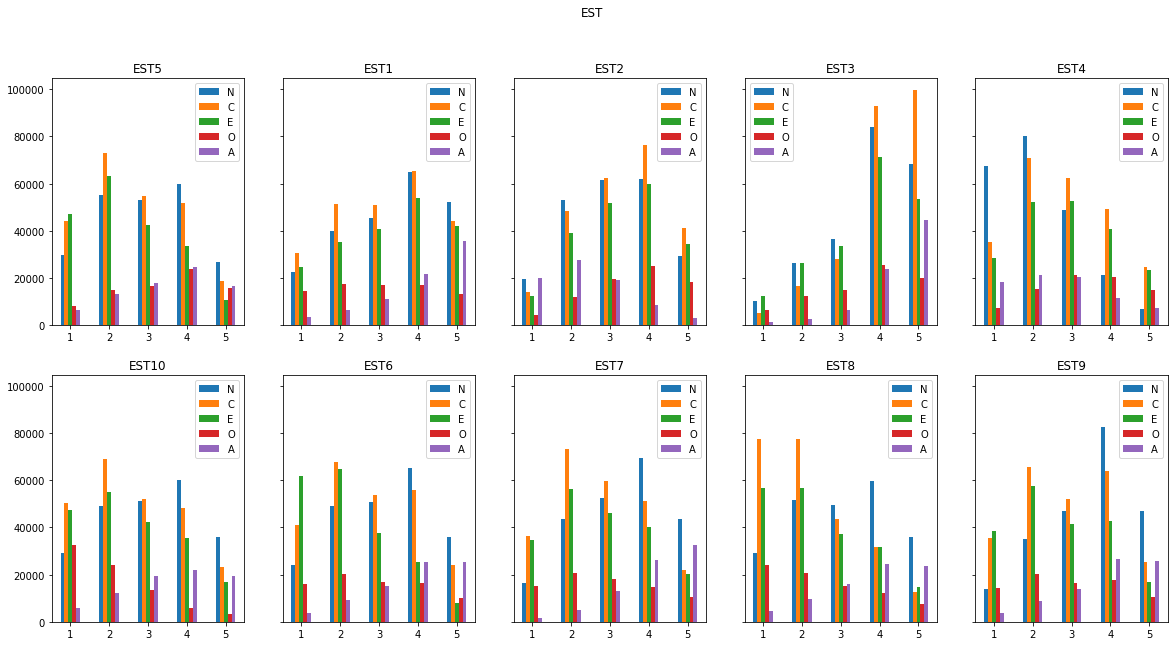

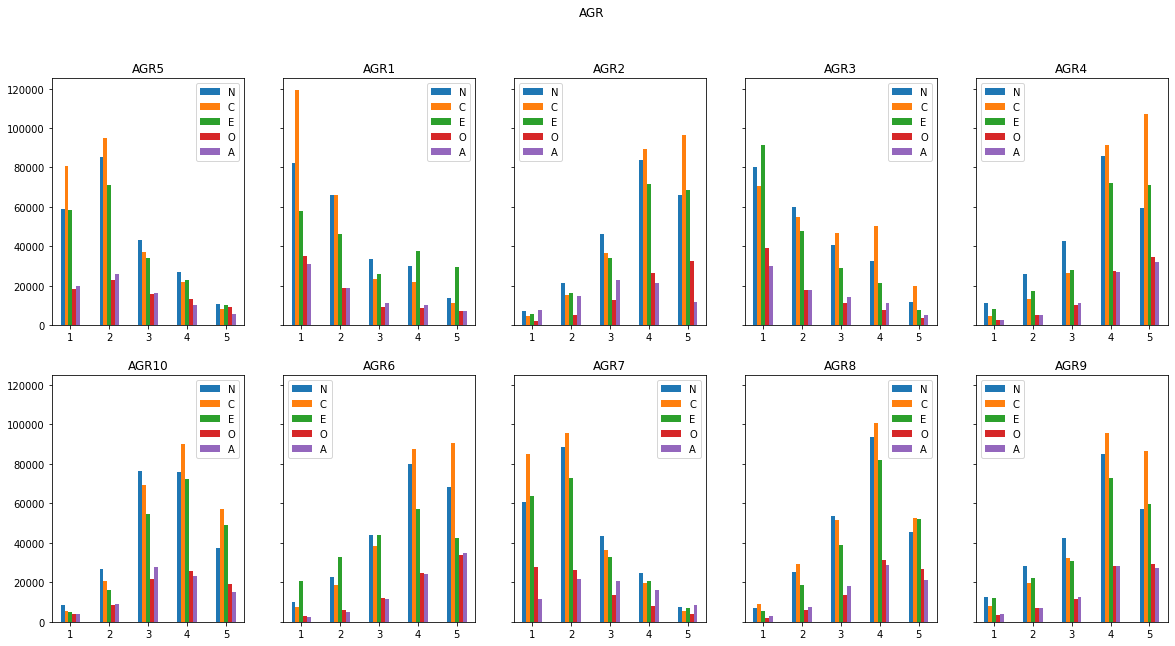

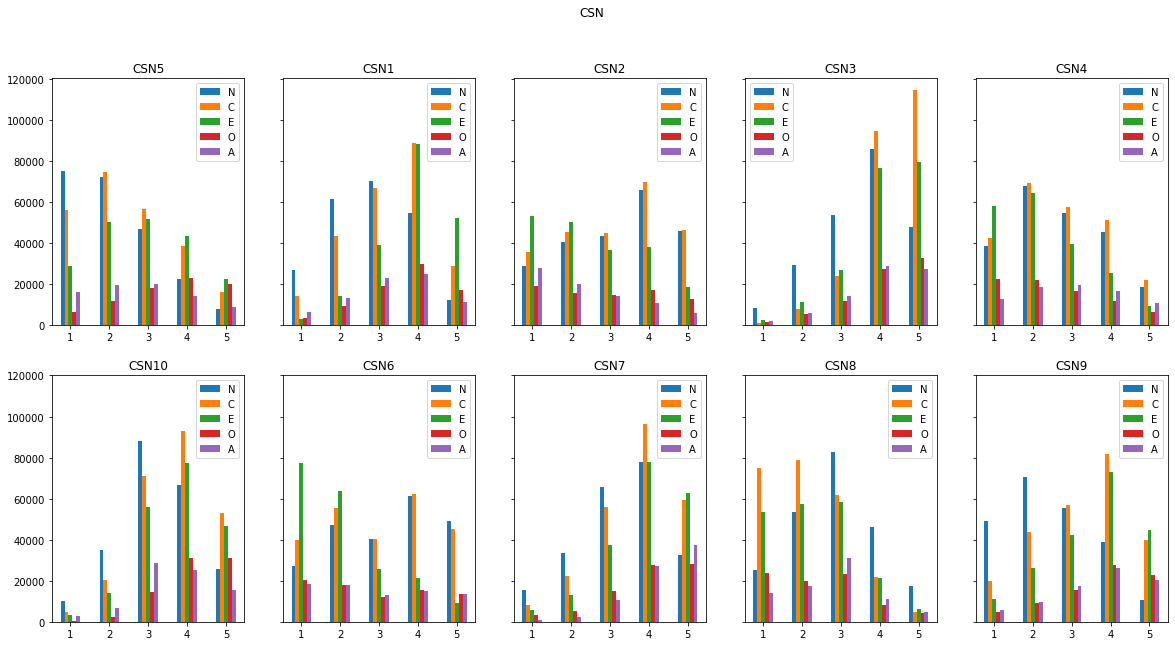

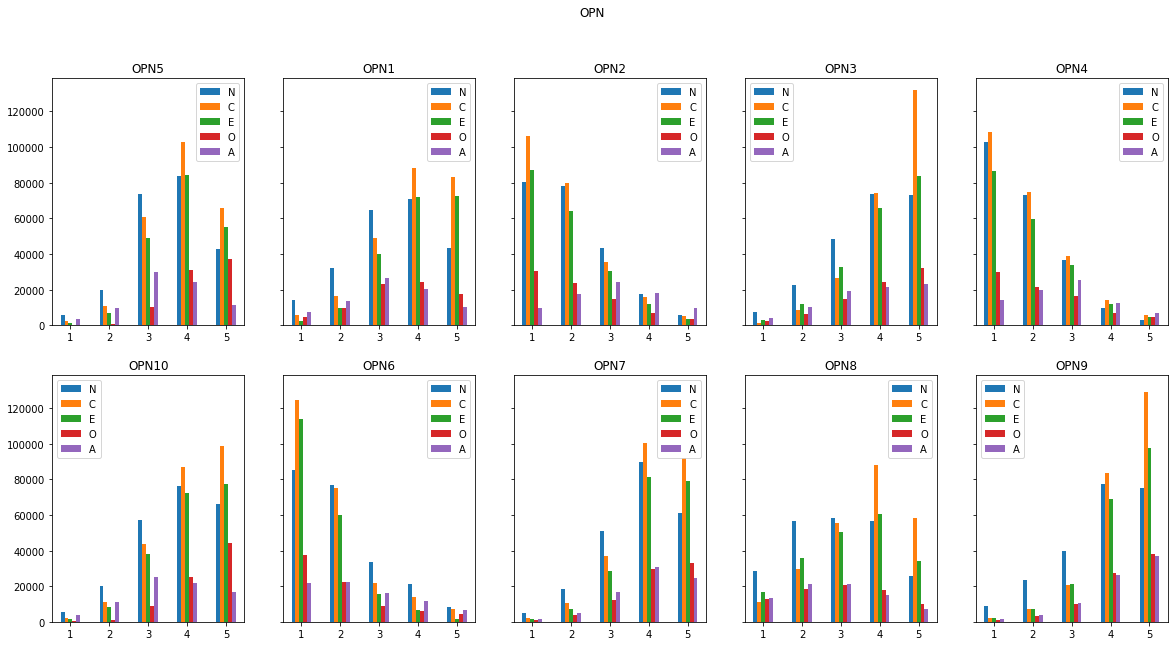

In [9]:
width = 0.1
for q in q_types:

    questions = [f"{q}{i}" for i in range(1, 11)]
    fig, axis = plt.subplots(ncols=5, nrows=2, figsize=(20, 10), sharey=True)
    fig.suptitle(q)
    for j, question in enumerate(questions):
        ax = axis[round((j+1)/10), (j + 1) % 5]
        ax.set_title(question)
        targets_data = [df[df['target'] == target][question].value_counts().sort_index() for target in targets]
        for i in range(len(targets_data)):
            ax.bar(targets_data[i].index + (i - 2) * width, targets_data[i], width, label=targets[i])
            ax.set_xticks(targets_data[i].index)
            ax.legend()

### Target Variable

In [10]:
target_classes = list(df['target'].unique())

`Extroversion (E)`: Altos puntajes tienden a ser personas muy sociables, mientras que bajos puntajes prefieren trabajar solos en proyectos.  
`Agreeableness (A)`: Altos puntajes tienen a ser personas con comportamiento políticamente correcto, mientras que bajos puntajes tienden a ser personas muy directas.  
`Conscientiouness (C)`: Altos puntajes tienen a ser personas que siguen las reglas y prefieren el orden, mientras que bajos puntajes tienden a ser personas desordenadas.  
`Neuroticism (N)`: El nivel “ser emocional” de una persona.  
`Openness to Experience (O)`: Altos puntajes tienden a ser personas que “sueñan despiertas”, mientras que bajos puntajes tienden a “estar con los pies sobre la tierra”.

C    242510
N    225175
E    197162
O     79375
A     78703
Name: target, dtype: int64


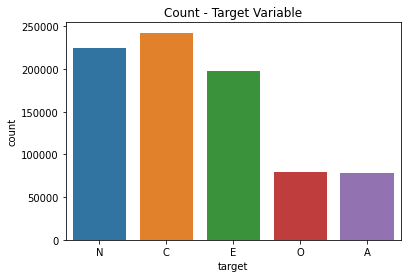

In [11]:
print(df['target'].value_counts())
sns.countplot(df['target'],order = target_classes)
plt.title('Count - Target Variable')
plt.show()

## Data Transformation
- Conversion of milliseconds to minutes  
- Drop of outliers using IQR

In [12]:
df_columns = df.columns
time_columns = []

for col in df_columns:
    if '_E' in str(col):
        time_columns.append(col)
        df[col] = df[col].apply(lambda x: abs(x/1000/60))
        q1 = df[col].quantile(0.25)
        q2 = df[col].quantile(0.50)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        df[col] = df[col].apply(lambda x: q2 if (x>=q3 + 1.5*iqr) else x)

## Feature Selection

Start by dropping the columns with no useful information.

In [13]:
labels = ['dateload','screenw','screenh','IPC',
          'testelapse','endelapse','introelapse',
          'country','lat_appx_lots_of_err','long_appx_lots_of_err']
df.drop(labels = labels, inplace = True, axis = 1)

Encode target variable from letters to numbers.

In [14]:
le = LabelEncoder()
le.fit(target_classes)
df['target'] = le.transform(df['target'])
print(f'Before encoding:{target_classes}')
print(f'After encoding: {le.transform(le.classes_)}')

Before encoding:['N', 'C', 'E', 'O', 'A']
After encoding: [0 1 2 3 4]


### Chi - Squared: Selecting the Best k Features

In [15]:
bestfeatures = SelectKBest(score_func=chi2, k=52)
fit = bestfeatures.fit(df.drop('target',axis=1),df['target'])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(df.drop('target',axis=1).columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']
featureScores.sort_values(by='Score',ascending=False).head(52)

,Feature,Score
17,EST8,"62,879.49"
35,CSN6,"56,973.29"
15,EST6,"55,046.56"
38,CSN9,"51,709.59"
34,CSN5,"46,085.13"
16,EST7,"44,817.02"
19,EST10,"41,723.46"
41,OPN2,"39,691.30"
18,EST9,"37,909.29"
30,CSN1,"35,380.77"


The time columns will be dropped, following Chi-Squared results. Keeping 50 features in total.

In [16]:
df.drop(labels = time_columns, axis=1,inplace = True)
col = df.drop('target',axis=1).columns.values
print(f'Models will be trained with the following features {col}')

Models will be trained with the following features ['EXT1' 'EXT2' 'EXT3' 'EXT4' 'EXT5' 'EXT6' 'EXT7' 'EXT8' 'EXT9' 'EXT10'
 'EST1' 'EST2' 'EST3' 'EST4' 'EST5' 'EST6' 'EST7' 'EST8' 'EST9' 'EST10'
 'AGR1' 'AGR2' 'AGR3' 'AGR4' 'AGR5' 'AGR6' 'AGR7' 'AGR8' 'AGR9' 'AGR10'
 'CSN1' 'CSN2' 'CSN3' 'CSN4' 'CSN5' 'CSN6' 'CSN7' 'CSN8' 'CSN9' 'CSN10'
 'OPN1' 'OPN2' 'OPN3' 'OPN4' 'OPN5' 'OPN6' 'OPN7' 'OPN8' 'OPN9' 'OPN10']


### Correlation Matrix

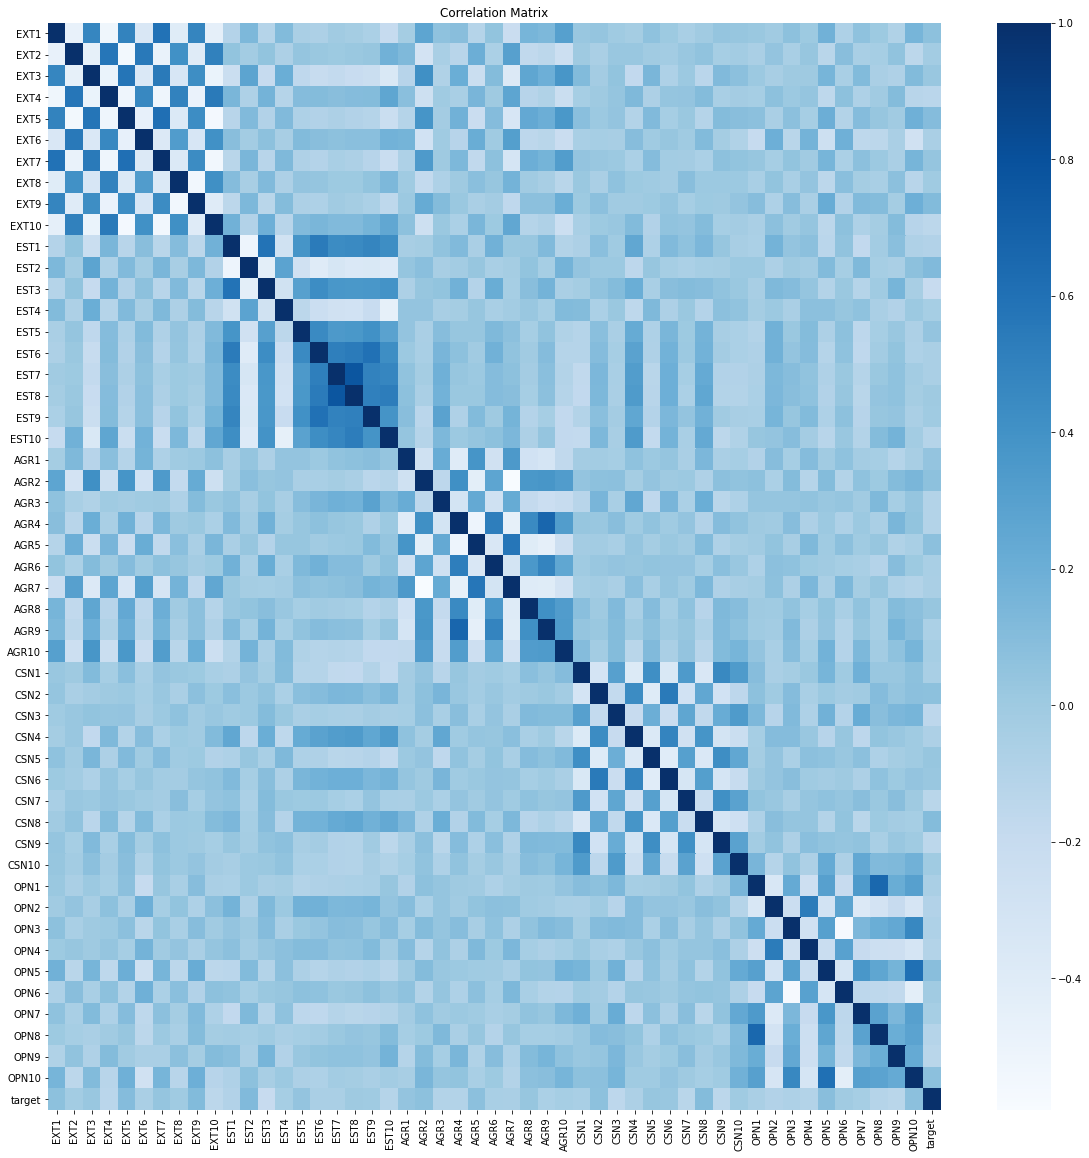

In [17]:
corr = df.corr()
fig,ax = plt.subplots(1,1,figsize=(20,20))
sns.heatmap(corr,cmap='Blues')
plt.title('Correlation Matrix')
plt.show()

Some clusters along common subject of anwers can be found in the correlation matrix, but there is no significant correlation between variables which can lead to a multicolinearity.

# Modelling

## Undersampling

Let's fit different models and compare the results between them. First, let's create our training and test sets. Since we have a rather strong imbalance in our data, we are going to create our train/test sets based on a subset of total data in which every target value has the same proportion.

In [18]:
sm = RandomUnderSampler(random_state=0,sampling_strategy='all')
X_res, y_res = sm.fit_resample(df.drop('target',axis=1), df['target'])
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0, shuffle=True)

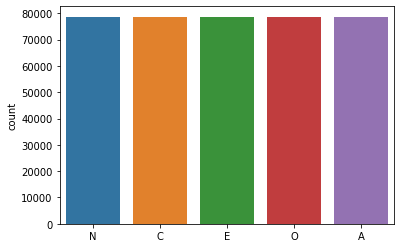

In [19]:
sns.countplot(le.inverse_transform(y_res),order = target_classes)
plt.show()

Create a dictionary to store the trained models.

In [20]:
models = {}

### Logistic Regression

In [21]:
logistic = LogisticRegression(n_jobs=-1, max_iter=300,random_state=0)
logistic.fit(X_train, y_train)
models[str(type(logistic).__name__)] = logistic

### SGD Classifier

In [22]:
sgd = SGDClassifier(random_state=0,alpha=1e-5,epsilon=1e-2,average=True,loss='log',early_stopping=True)
sgd.fit(X_train,y_train)
models[str(type(sgd).__name__)] = sgd

### Random Forest

In [23]:
randomf = RandomForestClassifier(criterion='gini',n_estimators=50,random_state=0,max_depth=50)
randomf.fit(X_train,y_train)
models[str(type(randomf).__name__)] = randomf

### Bayes Classifier

In [24]:
bayes = CategoricalNB()
bayes.fit(X_train, y_train)
models[str(type(bayes).__name__)] = bayes

## Error Analysis

Function which plots the confusion matrix for multiple models.

In [25]:
def plot_conf_mat(models,X,y,label):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
    fig.suptitle(f'Confusion Matrix - {label}',fontsize=16)

    for model, ax in zip(models, axes.flatten()):
        estimator = models[str(model)]

        plot_confusion_matrix(estimator, 
                              X, 
                              y, 
                              ax=ax, 
                              cmap='Blues',
                              normalize= 'all',
                              values_format = '.2f',
                              display_labels=le.inverse_transform(list(range(5))))
        ax.title.set_text(type(estimator).__name__)
        ax.set_xlabel('Predicted label')
        ax.set_ylabel('True label')
    plt.show()

Function which prints the classification report for each model.

In [26]:
def classif_report(models,X_test,y_test):
    for model in models:

        estimator = models[str(model)]
        y_pred = models[str(model)].predict(X_test)
        report = classification_report(y_test,y_pred,
                                       output_dict=True,
                                       target_names=le.inverse_transform(list(range(5))))
        clsf_report = pd.DataFrame(report).transpose()
        print(model)
        print(clsf_report)
        print()

Function which print the accuracy of the models.

In [27]:
def accuracy_score_models(models,X_test):
    for model in models:
        estimator = models[str(model)]
        y_pred = estimator.predict(X_test)
        print(type(estimator).__name__, round(accuracy_score(y_test, y_pred),2))

Function which plots ROC Curve for the multiclass case.

In [28]:
def plot_roc_curve_multiclass(estimator,X,y,label = None):
    # Binarize the output
    y = label_binarize(y, classes=[0,1,2,3,4])
    n_classes = y.shape[1]

    # shuffle and split training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,random_state=0,shuffle=True)

    # Learn to predict each class against the other
    y_score = estimator.decision_function(X_test)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    lw = 2

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(8,8))

    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue','darkviolet','gold'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'''.format(le.inverse_transform([i])[0],roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw,label='No Skill (area = 0.50)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate',fontsize=12)
    plt.ylabel('True Positive Rate',fontsize=12)
    plt.title(f'ROC Curve - {type(estimator).__name__} {label}',fontsize=12)
    plt.legend(loc="lower right",frameon=False,fontsize=12)
    plt.show()

### Confusion Matrix

#### Training Set

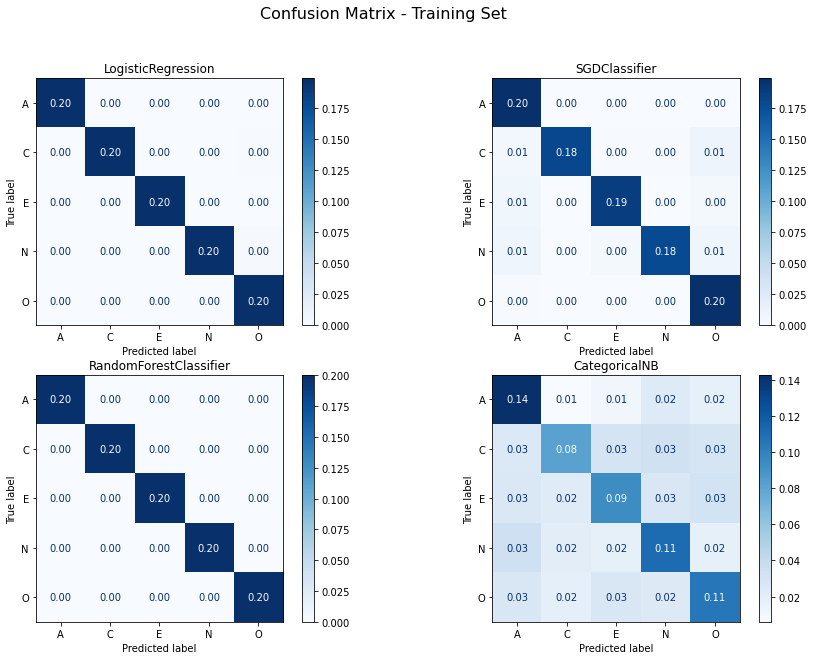

In [29]:
plot_conf_mat(models,X_train,y_train,label='Training Set')

### Test Set

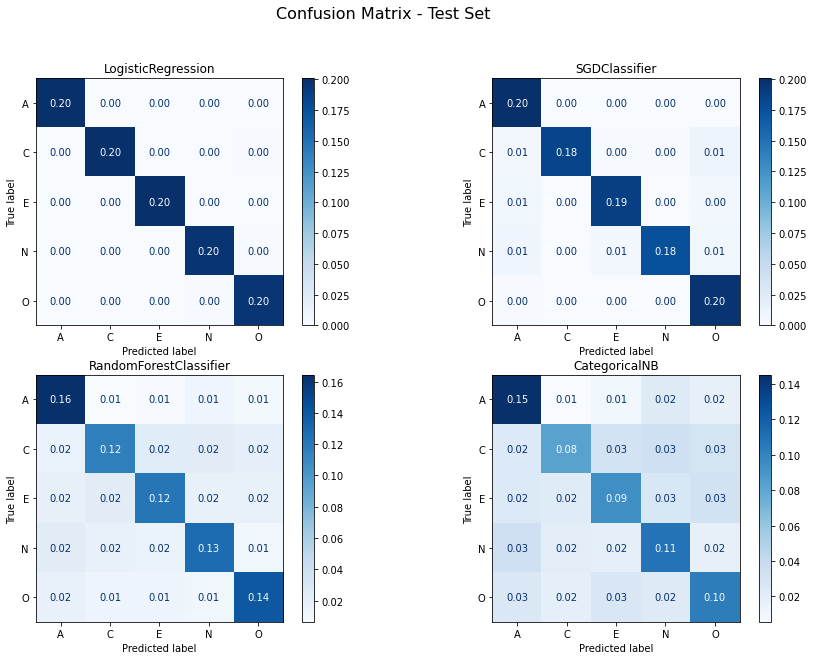

In [30]:
plot_conf_mat(models,X_test,y_test,label='Test Set')

### Classification Report

In [31]:
classif_report(models,X_test,y_test)

LogisticRegression
              precision  recall  f1-score   support
A                  0.99    1.00      1.00 15,842.00
C                  1.00    0.99      1.00 15,903.00
E                  1.00    1.00      1.00 15,784.00
N                  0.99    0.99      0.99 15,591.00
O                  0.99    0.99      0.99 15,583.00
accuracy           0.99    0.99      0.99      0.99
macro avg          0.99    0.99      0.99 78,703.00
weighted avg       0.99    0.99      0.99 78,703.00

SGDClassifier
              precision  recall  f1-score   support
A                  0.90    1.00      0.94 15,842.00
C                  1.00    0.91      0.95 15,903.00
E                  0.97    0.94      0.95 15,784.00
N                  0.99    0.89      0.94 15,591.00
O                  0.90    1.00      0.94 15,583.00
accuracy           0.95    0.95      0.95      0.95
macro avg          0.95    0.95      0.95 78,703.00
weighted avg       0.95    0.95      0.95 78,703.00

RandomForestClassifier
      

### Accuracy Score

In [32]:
accuracy_score_models(models,X_test)

LogisticRegression 0.99
SGDClassifier 0.95
RandomForestClassifier 0.67
CategoricalNB 0.53


### Receiving Operating Characteristic Curve - Best Model

<ipython-input-28-3a01f2ff981b>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


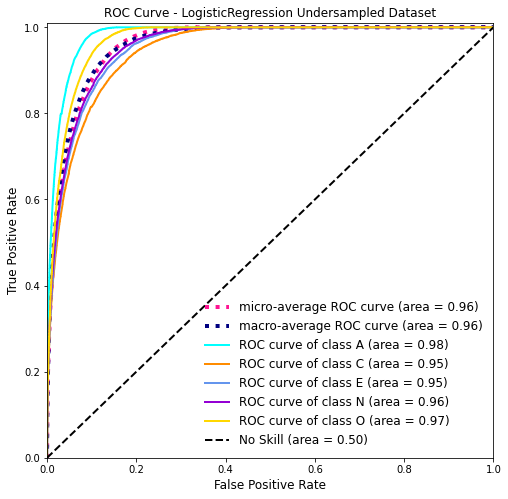

In [33]:
plot_roc_curve_multiclass(models['LogisticRegression'], X_res, y_res, label = 'Undersampled Dataset')

## Over Sampling

In [34]:
sm = RandomOverSampler(random_state=0,sampling_strategy='all')
X_res, y_res = sm.fit_resample(df.drop('target',axis=1), df['target'])
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0, shuffle=True)

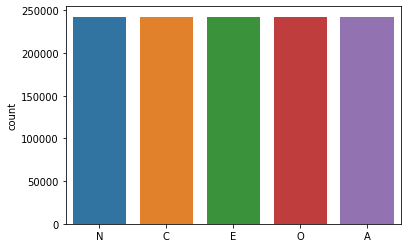

In [35]:
sns.countplot(le.inverse_transform(y_res),order=target_classes)
plt.show()

In [36]:
models = {}

### Logistic Regression

In [37]:
logistic.fit(X_train, y_train)
models[str(type(logistic).__name__)] = logistic

### SGD Classifier

In [38]:
sgd.fit(X_train,y_train)
models[str(type(sgd).__name__)] = sgd

### Random Forest

In [39]:
randomf.fit(X_train,y_train)
models[str(type(randomf).__name__)] = randomf

### Bayes Classifier

In [40]:
bayes.fit(X_train, y_train)
models[str(type(bayes).__name__)] = bayes

## Error Analysis

### Confusion Matrix

#### Training Set

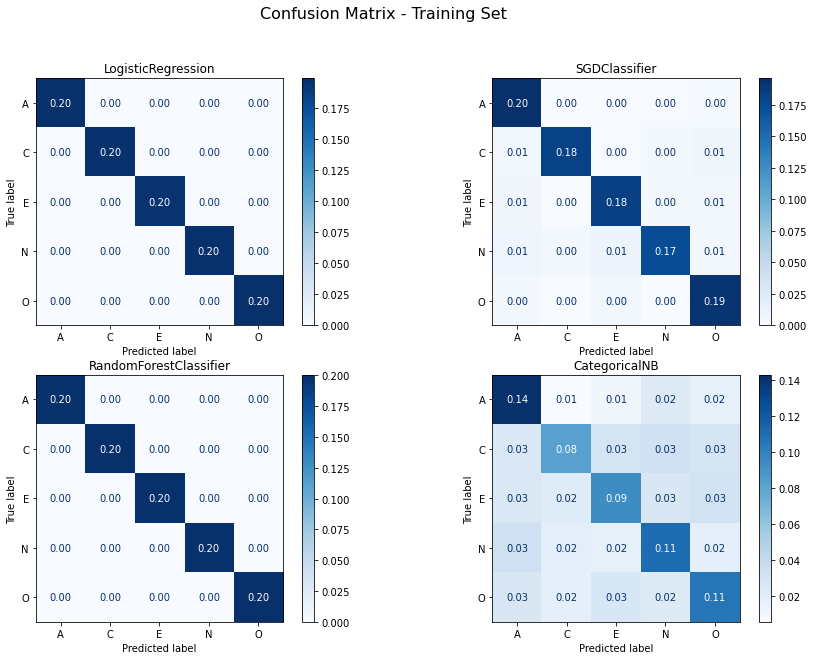

In [41]:
plot_conf_mat(models,X_train,y_train,label='Training Set')

#### Test Set

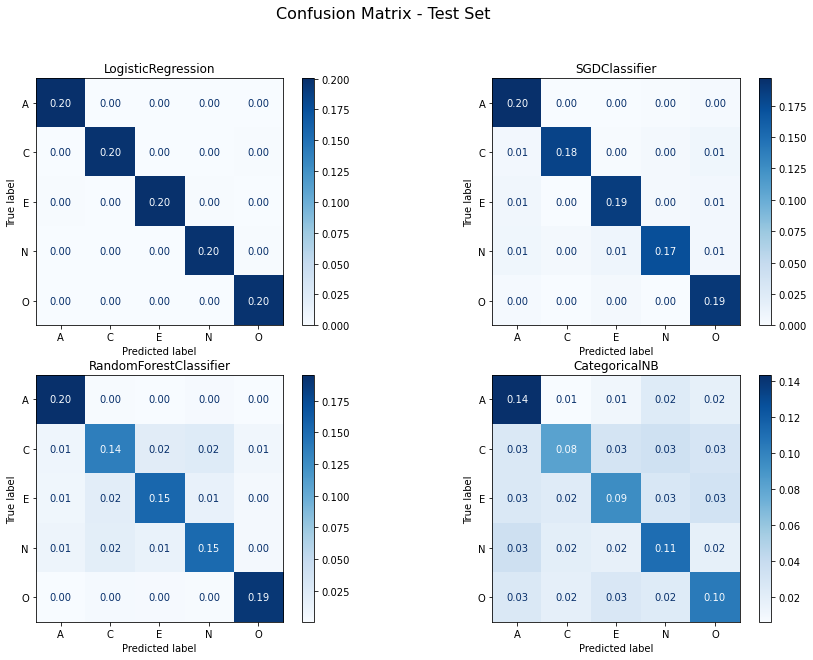

In [42]:
plot_conf_mat(models,X_test,y_test,label='Test Set')

### Classification Report

In [43]:
classif_report(models,X_test,y_test)

LogisticRegression
              precision  recall  f1-score    support
A                  0.99    1.00      0.99  48,711.00
C                  1.00    0.99      0.99  48,458.00
E                  1.00    0.99      0.99  48,897.00
N                  0.99    0.99      0.99  48,364.00
O                  0.98    0.99      0.99  48,080.00
accuracy           0.99    0.99      0.99       0.99
macro avg          0.99    0.99      0.99 242,510.00
weighted avg       0.99    0.99      0.99 242,510.00

SGDClassifier
              precision  recall  f1-score    support
A                  0.90    0.98      0.94  48,711.00
C                  0.98    0.91      0.94  48,458.00
E                  0.93    0.92      0.93  48,897.00
N                  0.95    0.87      0.91  48,364.00
O                  0.90    0.96      0.93  48,080.00
accuracy           0.93    0.93      0.93       0.93
macro avg          0.93    0.93      0.93 242,510.00
weighted avg       0.93    0.93      0.93 242,510.00

RandomFores

### Accuracy Score

In [44]:
accuracy_score_models(models,X_test)

LogisticRegression 0.99
SGDClassifier 0.93
RandomForestClassifier 0.83
CategoricalNB 0.53


### ROC Curve  - Best Model

<ipython-input-28-3a01f2ff981b>:31: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


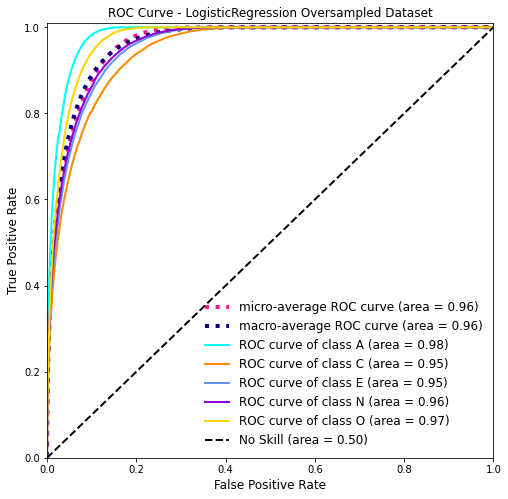

In [45]:
plot_roc_curve_multiclass(models['LogisticRegression'],X_res,y_res, label = 'Oversampled Dataset')